# Step 3: Optimization with uncertain conversion rates

In [ ]:
# fixed graph weights (same click influence probabilities between the products for each user)
# homogeneous users (one class with small variability)
# fixed alphas (same number of users each day distributed equally between the initial webpages)
# uncertain conversion rates

In [ ]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.TS_Learner import *
from Algorithms.UCB_Learner import *

In [ ]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.4, 0.4, 0.4, 0.4],[19.99, 21.99, 23.99, 26.99]))
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.4, 0.4, 0.4, 0.4],[29.99, 32.59, 35.99, 39.99]))
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.4, 0.4, 0.4, 0.4],[25.99,28.99, 31.99, 34.99]))
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,43.99,46.99, 49.99]))
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.4, 0.4, 0.4, 0.4],[79.99,89.99, 99.99, 109.99]))
# shoes

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
print("Margin matrix: ")
print(margins_matrix)

E = E_commerce()
E.graph = np.array([[0. , 0., 1. , 0.5 , 0. ],[0. , 0. , 0.5 , 1., 0. ],[0.5 , 1. , 0. , 0. , 0. ],[1. , 0.5 , 0. , 0. , 0. ],[0. , 0.5 , 0. , 1. , 0. ]])
E.set_products(products)
E.set_lambda(0.5)

Using a simple algorithm trained for a long time (1000 days, repeated 10 times), we obtain an estimation of conversion rates and expected rewards of the arms for each product. This will be considered our clairvoyant solution.

In [ ]:
# Random algorithm which for each round pulls a random choice
# to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
# useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 100 #mean number of users for each day
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_experiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_experiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given choosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i]
                                        * np.mean(mean_units_sold_per_product_per_experiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Rewards per arm of this simple algorithm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("Expected rewards per arm = margin * conversion rate")
print(margins_matrix*np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_experiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms


## Thompson Sampling: optimization of the cumulative expected margin over all the products

In [ ]:
print("Margin matrix: ")
print(margins_matrix)
print("Estimated conversion rates: ")
print(np.mean(conv_rates_per_experiment,axis=0))
print("Expected rewards per arm = margin * conversion rate ")
print(np.mean(conv_rates_per_experiment,axis=0)*margins_matrix)

In [ ]:
# Thompson Sampling
# Comparison between TS and UCB

n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 10

ts_rewards_per_experiment = []

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)


In [ ]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.legend(["TS"])
plt.show()

In [ ]:
print("_______________________________________________")
print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print(np.mean(np.sum(ts_rewards_per_experiment, axis=1)),np.std(np.sum(ts_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print(np.mean(np.sum(opt - ts_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ts_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(ts_rewards_per_experiment, axis=0)), np.std(np.mean(ts_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(opt-ts_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ts_rewards_per_experiment, axis=0)))


In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,3))
ax[0].plot((np.mean(ts_rewards_per_experiment, axis=0)), 'r')
ax[0].set_title("Expected reward per round")
ax[1].plot((np.mean(opt-ts_rewards_per_experiment, axis=0)), 'r')
ax[1].set_title("Expected regret per round")

In [ ]:
#Considering one experiment to have an idea about expected rewards per arm and number of pulls per arm
print("_______________________________________________")
print("Expected rewards per arm for the last experiment")    
print(ts_learner.expected_rewards)
print("_______________________________________________")
print("Pulls per arm for the last experiment")
for i in range(5):
    pulls_per_arm = [len(ts_learner.rewards_per_arm[i][0])-1,len(ts_learner.rewards_per_arm[i][1])-1,len(ts_learner.rewards_per_arm[i][2])-1,len(ts_learner.rewards_per_arm[i][3])-1]

    print(pulls_per_arm)

## UCB: : optimization of the cumulative expected margin over all the products

In [ ]:
#UCB
n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 10

ucb_rewards_per_experiment = []

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights, fixed_units)
    ucb_learner = UCB(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


In [ ]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["UCB"])
plt.show()

In [ ]:
print("_______________________________________________")
print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation between", n_experiments,"experiments")
print(np.mean(np.sum(ucb_rewards_per_experiment, axis=1)),np.std(np.sum(ucb_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation between", n_experiments,"experiments")
print(np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ucb_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(ucb_rewards_per_experiment, axis=0)), np.std(np.mean(ucb_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(opt-ucb_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ucb_rewards_per_experiment, axis=0)))


In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,3))
ax[0].plot((np.mean(ucb_rewards_per_experiment, axis=0)), 'b')
ax[0].set_title("Expected reward per round")
ax[1].plot((np.mean(opt-ucb_rewards_per_experiment, axis=0)), 'b')
ax[1].set_title("Expected regret per round")

In [ ]:
#Considering one experiment to have an idea about expected rewards per arm and number of pulls per arm
print("_______________________________________________")
print("Expected rewards per arm for the last experiment")    
print(ucb_learner.expected_rewards)
print("_______________________________________________")
print("Pulls per arm for the last experiment")
for i in range(5):
    pulls_per_arm = [len(ucb_learner.rewards_per_arm[i][0])-1,len(ucb_learner.rewards_per_arm[i][1])-1,len(ucb_learner.rewards_per_arm[i][2])-1,len(ucb_learner.rewards_per_arm[i][3])-1]

    print(pulls_per_arm)

print("_______________________________________________")
print("Upper confidence bounds for the last experiment")
print(ucb_learner.confidence)

In [ ]:
#Theoretical comparison (?)

opt_per_product = np.zeros(5)
delta_arms_per_product = np.zeros((5,4)) #differencees with the mean reward of the optimal arm
upper_bound_regret_per_product = np.zeros(5)
for i in range(5):
    opt_per_product[i] = np.max(margins_matrix[i,:] * conversion_rates[i])
    for j in range(4):
        delta_arms_per_product[i,j] = opt_per_product[i] - ucb_learner.expected_rewards[i,j]
        if delta_arms_per_product[i,j]>0:
            upper_bound_regret_per_product[i] += 4*np.log(ucb_learner.t)/delta_arms_per_product[i,j] + 8*delta_arms_per_product[i,j]
   

#R(UCB)<SUM(4*np.log(ucb_learner.t)/delta_arms_per_product[i,j] + 8*delta_arms_per_product[i,j])
print("Upper bound theoretical regret per product")
print(upper_bound_regret_per_product)
print("Ratio between empiric regret and the upper bound")
empiric_regret = np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1))
print(empiric_regret/np.sum(upper_bound_regret_per_product))

Greedy Learner: each round chose the current best solution

In [35]:
# (INUTILE)
#Greedy Learner
n_arms = 4

num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
margins_matrix = np.array([[2.,  5.,  8., 11.], [4.,  7., 10., 13.],[6.,  9., 12., 15.],[ 8., 11., 14., 17],[10., 13., 16., 19.]])

env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units=1)
gr_learner = Greedy(n_arms=n_arms)

for d in range(n_days):
    
    pulled_arm = gr_learner.pull_arm(env.margins_matrix)
    reward = env.round(pulled_arm)
    gr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)

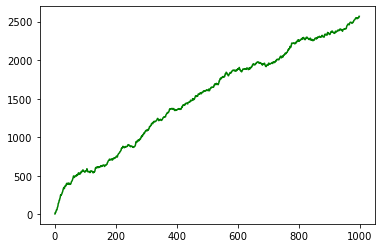

In [36]:
plt.plot(np.cumsum(opt-gr_learner.collected_rewards),'g')